In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

#loading data
file_1="/workspaces/State-of-Health-Estimation-Battery/Dataset/B0005_dis_dataset.csv"
dataset=pd.read_csv(file_1)

C_max=2

#renaming columns for simplicity
dataset.columns=['cycle',"capacity",'voltage', 'current','temperature', 'current_load', 'voltage_load',"time"]
dataset["current_load"]= abs(dataset["current_load"])

#removing ideling / starting and ending current level data  
df=dataset[(dataset.current_load>=0.006)].reset_index(drop=True)

# converting time seconds->hour
df["time"]=df["time"]/3600

#calculate Soc for each cycle
cycle_count=df["cycle"].unique()
Soc_list=[]

# Update Soc for each reading within each cycle using Coulomb counting
for cycle in cycle_count:
    cycle_data = df[df['cycle'] == cycle]
    
    cumulative_Soc = [sum(cycle_data["capacity"])/len(cycle_data["capacity"])]
    
    for i in range(1, len(cycle_data)):
        
        delta_time = cycle_data['time'].iloc[i-1] - cycle_data['time'].iloc[i]
        
        delta_charge = cycle_data['current'].iloc[i] * delta_time
        
        cumulative_Soc.append(cumulative_Soc[-1] -delta_charge)
        
    Soc_list.extend(cumulative_Soc)

#DOD is the opposite of the soc 
df["Soc"] = [(q / C_max) for q in Soc_list]
df["Soh"]=df["capacity"]/C_max

In [6]:
cor = df.corr()

<Axes: >

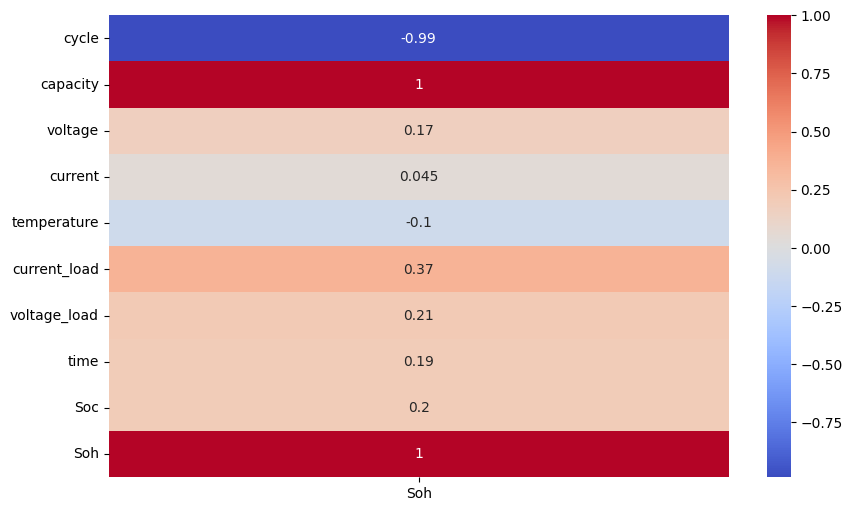

In [7]:
plt.figure(figsize=(10,6))  #select value out of range(0.05,-0.05)
sns.heatmap(cor[["Soh"]],annot=True,cmap='coolwarm')
#cycle,current_load

In [8]:
from sklearn.feature_selection import mutual_info_regression

In [9]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y,)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [11]:
X=["cycle","capacity","voltage","current","temperature","current_load","voltage_load","time","Soc"]
mi_scores = make_mi_scores(df[X],df[["Soh"]])

/home/codespace/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1310: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [12]:
mi_scores

cycle           5.106268
capacity        5.103665
current_load    0.205032
current         0.013245
voltage         0.000000
temperature     0.000000
voltage_load    0.000000
time            0.000000
Soc             0.000000
Name: MI Scores, dtype: float64

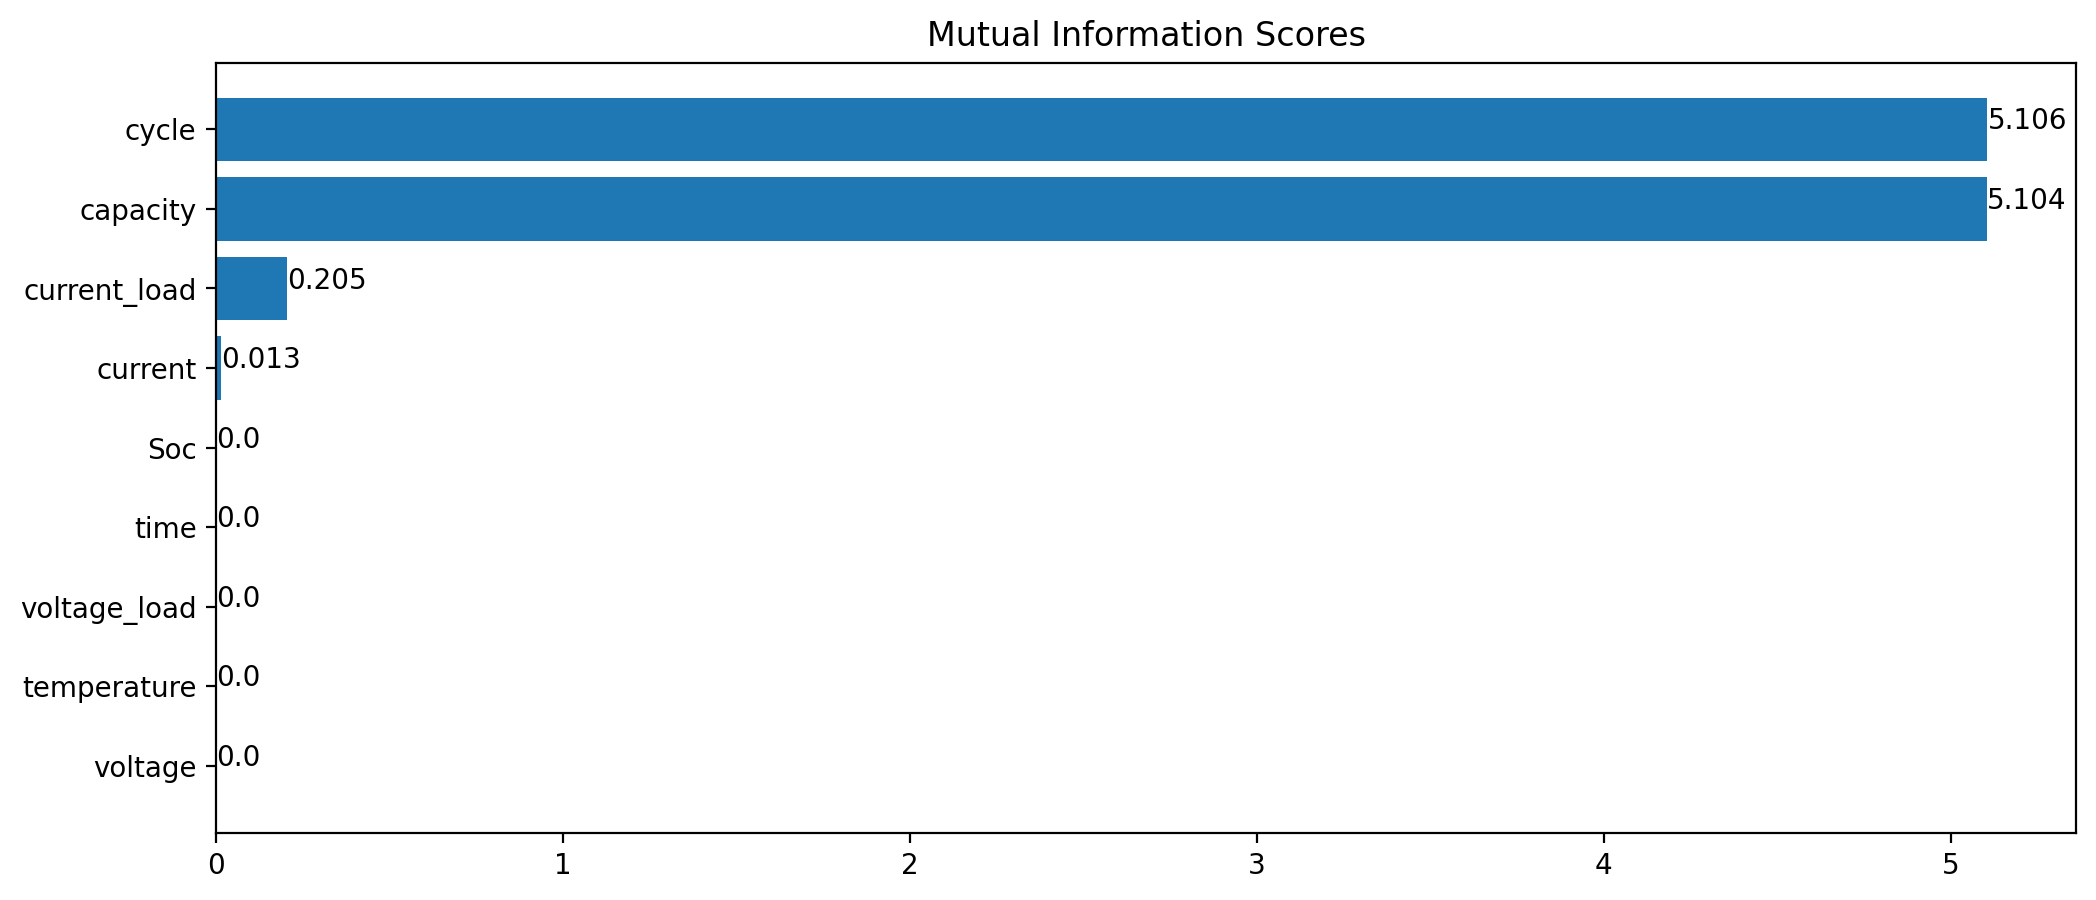

In [13]:
def plot_mi_scores(scores):
    plt.figure(dpi=200, figsize=(12, 5))
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    for index, value in enumerate(scores):
        plt.text(value, index,str(round(value,3)))
plot_mi_scores(mi_scores)